In [ ]:
! pip install torchmetrics

In [68]:
import re
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchmetrics.functional import f1
from string import punctuation
from nltk import TweetTokenizer
import pandas as pd
from collections import Counter
from torch.nn.utils.rnn import pad_sequence
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader, RandomSampler, SequentialSampler
from tqdm import tqdm
from nltk.tokenize import word_tokenize
import nltk
nltk.download('punkt')
import matplotlib.pyplot as plt

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [2]:
col_names = ['id', 'date', 'name', 'text', 'type', 'rep', 'rtw', 'fav', 'stcount', 'foll', 'frien', 'listcount']

In [3]:
positive_df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/NNmethods/positive.csv", header=None, sep=';', names=col_names, index_col=0)

In [4]:
positive_df.head()

,date,name,text,type,rep,rtw,fav,stcount,foll,frien,listcount
id,,,,,,,,,,,
408906692374446080,1386325927,pleease_shut_up,"@first_timee хоть я и школота, но поверь, у на...",1,0,0,0,7569,62,61,0
408906692693221377,1386325927,alinakirpicheva,"Да, все-таки он немного похож на него. Но мой ...",1,0,0,0,11825,59,31,2
408906695083954177,1386325927,EvgeshaRe,RT @KatiaCheh: Ну ты идиотка) я испугалась за ...,1,0,1,0,1273,26,27,0
408906695356973056,1386325927,ikonnikova_21,"RT @digger2912: ""Кто то в углу сидит и погибае...",1,0,1,0,1549,19,17,0
408906761416867842,1386325943,JumpyAlex,@irina_dyshkant Вот что значит страшилка :D\nН...,1,0,0,0,597,16,23,1


In [5]:
negative_df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/NNmethods/negative.csv", header=None, sep=';', names=col_names, index_col=0)

In [6]:
all_df = pd.concat([positive_df, negative_df], ignore_index=True)

In [43]:
all_df["type"] = all_df["type"].replace([-1], 0)

In [8]:
def clean_tokens(tokens):
    clean_tokens = []
    for token in tokens:
        if token not in punctuation:
            clean_tokens.append(token)
    return clean_tokens

In [9]:
tw = TweetTokenizer()

In [10]:
def clean_tokenize(text):
    return clean_tokens(tw.tokenize(text))

In [44]:
tokenized_texts = []
for i in tqdm(range(len(all_df))):
  tokenized_texts.append(word_tokenize(all_df['text'].iloc[i]))

100%|██████████| 226834/226834 [01:01<00:00, 3681.92it/s]


In [11]:
clean_tokenized_texts = []
for text in tokenized_texts:
    text_tokens = []
    for thing in text:
        if thing not in punctuation:
            text_tokens.append(thing)
    clean_tokenized_texts.append(text_tokens)

In [45]:
all_df["text_tokenized"] = all_df["text"].apply(clean_tokenize)

In [46]:
all_df.head()

,date,name,text,type,rep,rtw,fav,stcount,foll,frien,listcount,text_tokenized
0,1386325927,pleease_shut_up,"@first_timee хоть я и школота, но поверь, у на...",1,0,0,0,7569,62,61,0,"[@first_timee, хоть, я, и, школота, но, поверь..."
1,1386325927,alinakirpicheva,"Да, все-таки он немного похож на него. Но мой ...",1,0,0,0,11825,59,31,2,"[Да, все-таки, он, немного, похож, на, него, Н..."
2,1386325927,EvgeshaRe,RT @KatiaCheh: Ну ты идиотка) я испугалась за ...,1,0,1,0,1273,26,27,0,"[RT, @KatiaCheh, Ну, ты, идиотка, я, испугалас..."
3,1386325927,ikonnikova_21,"RT @digger2912: ""Кто то в углу сидит и погибае...",1,0,1,0,1549,19,17,0,"[RT, @digger2912, Кто, то, в, углу, сидит, и, ..."
4,1386325943,JumpyAlex,@irina_dyshkant Вот что значит страшилка :D\nН...,1,0,0,0,597,16,23,1,"[@irina_dyshkant, Вот, что, значит, страшилка,..."


In [47]:
train_data, val_data = train_test_split(all_df, test_size=0.2)

In [48]:
vocab = Counter()
for tokens in all_df['text_tokenized']:
        vocab.update(list([token.lower() for token in tokens]))
print('всего уникальных токенов:', len(vocab))

всего уникальных токенов: 302594


In [49]:
filtered_vocab = set()

for token in vocab:
    if vocab[token] > 10:
        filtered_vocab.add(token)
print('уникальных токенов, встретившихся более десяти раз:', len(filtered_vocab))

уникальных токенов, встретившихся более десяти раз: 17767


In [50]:
word2id = {'PAD':0}

for token in filtered_vocab:
    word2id[token] = len(word2id)

In [51]:
id2word = {i:word for word, i in word2id.items()}

In [52]:
DEVICE = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
DEVICE

device(type='cuda')

In [24]:
class TweetDataset(Dataset):

    def __init__(self, dataset, symbol2id, DEVICE):
        self.dataset = dataset['text_tokenized'].values
        self.word2id = word2id
        self.length = dataset.shape[0]
        self.target = dataset['type'].values
        self.device = DEVICE

    def __len__(self):
        return self.length

    def __getitem__(self, index): 
        tokens = list(self.dataset[index])
        ids = torch.LongTensor([self.word2id[token] for token in tokens if token in self.word2id])
        y = [self.target[index]]
        return ids, y

    def collate_fn(self, batch):
        ids, y = list(zip(*batch))
        padded_ids = pad_sequence(ids, batch_first=True).to(self.device)
        y = torch.Tensor(y).to(self.device)
        return padded_ids, y

In [53]:
train_dataset = TweetDataset(train_data, word2id, DEVICE)
train_sampler = RandomSampler(train_dataset)
train_iterator = DataLoader(train_dataset, collate_fn=train_dataset.collate_fn, sampler=train_sampler, batch_size=1024)

In [54]:
batch = next(iter(train_iterator))

In [ ]:
[id2word[int(i)] for i in batch[0][0]]

In [57]:
val_dataset = TweetDataset(val_data, word2id, DEVICE)
val_sampler = SequentialSampler(val_dataset)
val_iterator = DataLoader(val_dataset, collate_fn = val_dataset.collate_fn, sampler=val_sampler, batch_size=1024)

In [58]:
test_batch = next(iter(val_iterator))

In [59]:
class CNN(nn.Module):
    
    def __init__(self, vocab_size, embedding_dim):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.bigrams = nn.Conv1d(in_channels=embedding_dim, out_channels=100, kernel_size=2, padding='same')
        self.trigrams = nn.Conv1d(in_channels=embedding_dim, out_channels=80, kernel_size=3, padding='same')
        self.bigrams2 = nn.Conv1d(in_channels=180, out_channels=100, kernel_size=2, padding='same')
        self.pooling = nn.MaxPool1d(kernel_size=2, stride=2)
        self.hidden = nn.Linear(in_features=100, out_features=1)
        self.out = nn.Sigmoid()
    
    def forward(self, word):
        embedded = self.embedding(word)
        embedded = embedded.transpose(1,2)
        feature_map_bigrams = self.bigrams(embedded)
        feature_map_trigrams = self.trigrams(embedded)
        concat = torch.cat((feature_map_bigrams, feature_map_trigrams), 1)
        concat_bigrams = self.bigrams2(concat)
        pooling = self.pooling(concat_bigrams)
        pooling = pooling.max(2)[0]

        logits = self.hidden(pooling) 
        logits = self.out(logits)      
        return logits

In [60]:
batch, y = next(iter(train_iterator))
batch, y = batch.to(device='cpu'), y.to(device='cpu')
print(batch)

tensor([[ 9795, 11495,  6679,  ...,     0,     0,     0],
        [ 4072,  7993, 10309,  ...,     0,     0,     0],
        [15793,  7086, 13089,  ...,     0,     0,     0],
        ...,
        [16029, 13089,   795,  ...,     0,     0,     0],
        [ 4732,  8978,  7993,  ...,     0,     0,     0],
        [13089,  1214,  5430,  ...,     0,     0,     0]])


In [61]:
loss = nn.BCELoss()

In [62]:
def train(model, iterator, optimizer, criterion):
    epoch_loss = 0

    model.train()

    for i, (texts, ys) in enumerate(iterator):
        optimizer.zero_grad()
        preds = model(texts)
        loss = criterion(preds, ys)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item() 
        if not (i + 1) % int(len(iterator)/5):
            print(f'Train loss: {epoch_loss/i}')      
    return  epoch_loss / len(iterator)

In [36]:
def evaluate(model, iterator, criterion):
    epoch_loss = 0
    epoch_metric = 0
    model.eval() 
    with torch.no_grad():
        for i, (texts, ys) in enumerate(iterator):   
            preds = model(texts)
            loss = criterion(preds, ys)
            epoch_loss += loss.item()
            batch_metric = f1(preds.round().long(), ys.long(), ignore_index=0)
            epoch_metric += batch_metric

            if not (i + 1) % int(len(iterator)/5):
                print(f'Val loss: {epoch_loss/i}, Val f1: {epoch_metric/i}')
        
    return epoch_metric / len(iterator), epoch_loss / len(iterator) # возвращаем среднее значение по всей выборке

In [63]:
model = CNN(len(word2id), 64)
optimizer = optim.Adam(model.parameters(), lr=0.0005)
criterion = nn.BCELoss()

In [64]:
model = model.to(DEVICE)
criterion = criterion.to(DEVICE)

In [66]:
def train_eval(model, t_iterator, v_iterator, optimizer, criterion, epochs=20):
    losses = []
    losses_eval = []
    f1s = []
    f1s_eval = []
    log = {'train_loss': [], 'val_loss': [], 'val_f1': []}

    for i in range(epochs):
        print(f'\nEpoch {i}')
        print('Training...')
        epoch_loss = train(model, t_iterator, optimizer, criterion)
        losses.append(epoch_loss)
        print('\nEvaluating on train...')
        f1_on_train,_ = evaluate(model, t_iterator, criterion)
        f1s.append(f1_on_train)
        print('\nEvaluating on test...')
        f1_on_test, epoch_loss_on_test = evaluate(model, v_iterator, criterion)
        losses_eval.append(epoch_loss_on_test)
        f1s_eval.append(f1_on_test)

        log['train_loss'] = losses
        log['val_loss'] = losses_eval    
        
        if i % 3 == 0:
            fig, axs = plt.subplots(1, len(log), figsize=(15, 5))
            for i, (name, vals) in enumerate(log.items()):
                axs[i].plot(vals)
                axs[i].set_title(name)
            plt.show()
            #print("  Train loss:      {0:.6f}".format(epoch_loss))
            #print("  Validation Loss: {0:.6f}".format(epoch_loss_on_test))
            #print("  Validation F1:   {0:.6f}".format(f1_on_test))
            log['val_f1'] = f1s_eval

    return losses, losses_eval, f1s, f1s_eval


Epoch 0
Training...
Train loss: 0.41531937087283416
Train loss: 0.40864016310028406
Train loss: 0.40673797090466207
Train loss: 0.4046849387583973
Train loss: 0.40368993152147054

Evaluating on train...
Val loss: 0.40105025557910695, Val f1: 0.8409174680709839
Val loss: 0.3959322174390157, Val f1: 0.8273431658744812
Val loss: 0.39282569833672965, Val f1: 0.8247847557067871
Val loss: 0.3919494572303278, Val f1: 0.8224071264266968
Val loss: 0.39117234739763984, Val f1: 0.8210773468017578

Evaluating on test...
Val loss: 0.46787380427122116, Val f1: 0.9008179903030396
Val loss: 0.43217485792496624, Val f1: 0.8489340543746948
Val loss: 0.4225975481363443, Val f1: 0.8334655165672302
Val loss: 0.419802177803857, Val f1: 0.8245019316673279
Val loss: 0.4196728447621519, Val f1: 0.8192203044891357


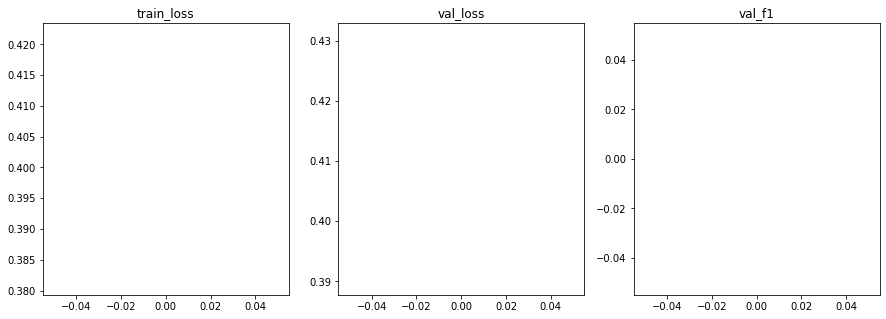


Epoch 1
Training...
Train loss: 0.39461400841965394
Train loss: 0.3899842064449753
Train loss: 0.38799261903533566
Train loss: 0.385672105302056
Train loss: 0.3854420902742737

Evaluating on train...
Val loss: 0.37905701030703154, Val f1: 0.8451213836669922
Val loss: 0.37369309516920557, Val f1: 0.8326358795166016
Val loss: 0.37065429154496926, Val f1: 0.8286646008491516
Val loss: 0.3700866471949241, Val f1: 0.8260218501091003
Val loss: 0.3703797680550608, Val f1: 0.8246683478355408

Evaluating on test...
Val loss: 0.4552186317741871, Val f1: 0.8952517509460449
Val loss: 0.4201034219825969, Val f1: 0.8427462577819824
Val loss: 0.41070920343582445, Val f1: 0.8256904482841492
Val loss: 0.40776666828564234, Val f1: 0.8169712424278259
Val loss: 0.4081321717663245, Val f1: 0.8109667897224426

Epoch 2
Training...
Train loss: 0.37848639137604656
Train loss: 0.3742382928081181
Train loss: 0.3712804910655205
Train loss: 0.371120019353551
Train loss: 0.3700901185986639

Evaluating on train...
V

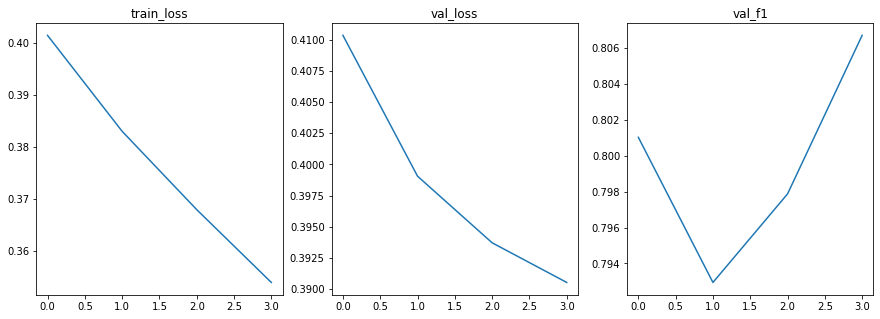


Epoch 4
Training...
Train loss: 0.3526131089995889
Train loss: 0.34633172335832013
Train loss: 0.34363960990538966
Train loss: 0.3428900351198457
Train loss: 0.3425021365113642

Evaluating on train...
Val loss: 0.3361051652361365, Val f1: 0.8782064318656921
Val loss: 0.329476374214974, Val f1: 0.8666061758995056
Val loss: 0.3287868674557943, Val f1: 0.8611223697662354
Val loss: 0.3288900206843726, Val f1: 0.8582538366317749
Val loss: 0.32888396101436396, Val f1: 0.8568647503852844

Evaluating on test...
Val loss: 0.4444117397069931, Val f1: 0.9129536151885986
Val loss: 0.4098432537387399, Val f1: 0.8588072657585144
Val loss: 0.39976537686127883, Val f1: 0.8422776460647583
Val loss: 0.39712891919272286, Val f1: 0.8335568308830261
Val loss: 0.3974892259998755, Val f1: 0.8274316191673279

Epoch 5
Training...
Train loss: 0.33485207750516777
Train loss: 0.33023659215457196
Train loss: 0.33151260448189884
Train loss: 0.3309886929371374
Train loss: 0.33159016997649754

Evaluating on train...

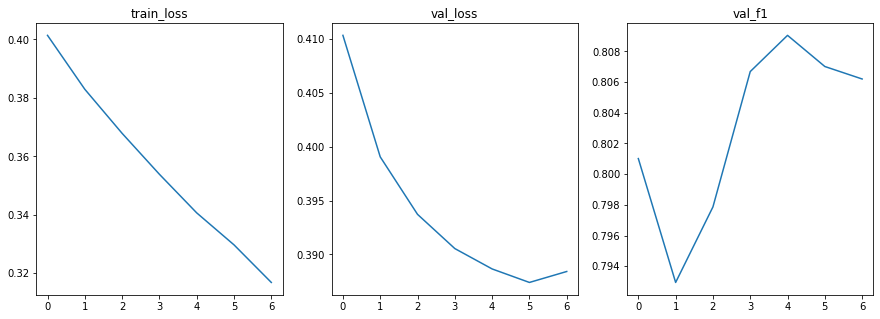


Epoch 7
Training...
Train loss: 0.31209512054920197
Train loss: 0.30816315438436426
Train loss: 0.3063069235246915
Train loss: 0.30693736372234154
Train loss: 0.30699061011445933

Evaluating on train...
Val loss: 0.2974131247576545, Val f1: 0.8971845507621765
Val loss: 0.2927349693533303, Val f1: 0.8838061690330505
Val loss: 0.2914300159766124, Val f1: 0.879663348197937
Val loss: 0.2912793693353804, Val f1: 0.8769816160202026
Val loss: 0.29156329576996554, Val f1: 0.8750948905944824

Evaluating on test...
Val loss: 0.44752079620957375, Val f1: 0.9001035690307617
Val loss: 0.41168209384469423, Val f1: 0.8499029874801636
Val loss: 0.40184662548395306, Val f1: 0.8350971937179565
Val loss: 0.39893905179841177, Val f1: 0.8265209794044495
Val loss: 0.3996323997324163, Val f1: 0.8207820653915405

Epoch 8
Training...
Train loss: 0.2979942113161087
Train loss: 0.29605138258657593
Train loss: 0.2958994464805493
Train loss: 0.2960878415502233
Train loss: 0.29704171025204934

Evaluating on train.

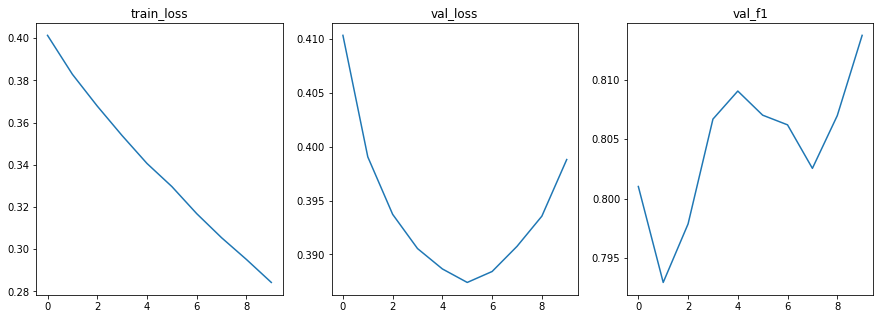


Epoch 10
Training...
Train loss: 0.2793974964057698
Train loss: 0.27610214616077533
Train loss: 0.27488593628200203
Train loss: 0.27496454730737124
Train loss: 0.2750011573749027

Evaluating on train...
Val loss: 0.26662381037193184, Val f1: 0.9128465056419373
Val loss: 0.2615418468696484, Val f1: 0.9014652967453003
Val loss: 0.25820123275312096, Val f1: 0.8986163139343262
Val loss: 0.25813567080943706, Val f1: 0.8961030840873718
Val loss: 0.25819124093000917, Val f1: 0.8941338062286377

Evaluating on test...
Val loss: 0.4614834785461426, Val f1: 0.9040651321411133
Val loss: 0.42370741332278533, Val f1: 0.8537020087242126
Val loss: 0.4132130719148196, Val f1: 0.839693546295166
Val loss: 0.40979737213679723, Val f1: 0.8317099213600159
Val loss: 0.4104314642873677, Val f1: 0.8265378475189209

Epoch 11
Training...
Train loss: 0.2647115360288059
Train loss: 0.26188393023566925
Train loss: 0.2627690468843167
Train loss: 0.2641324448070938
Train loss: 0.2647605699369277

Evaluating on train

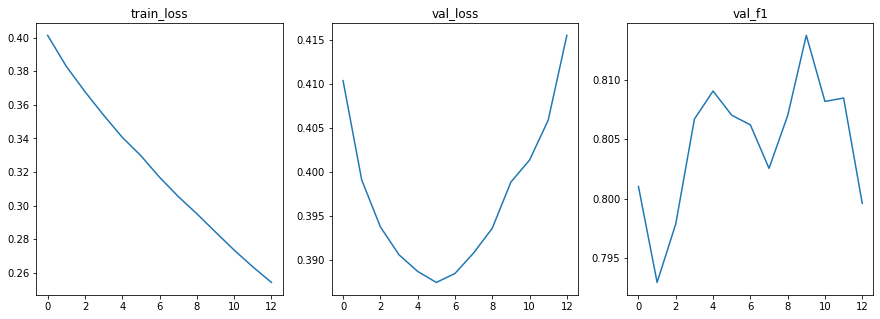


Epoch 13
Training...
Train loss: 0.24689952853847952
Train loss: 0.24535375164038892
Train loss: 0.24516363298663726
Train loss: 0.24573778366442206
Train loss: 0.24571721641154126

Evaluating on train...
Val loss: 0.23468900384271846, Val f1: 0.9328519701957703
Val loss: 0.2310622716727464, Val f1: 0.9199168086051941
Val loss: 0.23047453465943152, Val f1: 0.914938747882843
Val loss: 0.2291113754613794, Val f1: 0.9130130410194397
Val loss: 0.22872758408387503, Val f1: 0.9116231203079224

Evaluating on test...
Val loss: 0.4829351045191288, Val f1: 0.9117480516433716
Val loss: 0.44416353807729836, Val f1: 0.8595080971717834
Val loss: 0.4334586560726166, Val f1: 0.8440888524055481
Val loss: 0.4300775817462376, Val f1: 0.836663007736206
Val loss: 0.4304108348759738, Val f1: 0.8308736681938171

Epoch 14
Training...
Train loss: 0.23501218022669063
Train loss: 0.23402205563109854
Train loss: 0.23419970603516468
Train loss: 0.23476888132181098
Train loss: 0.23557068082107896

Evaluating on tr

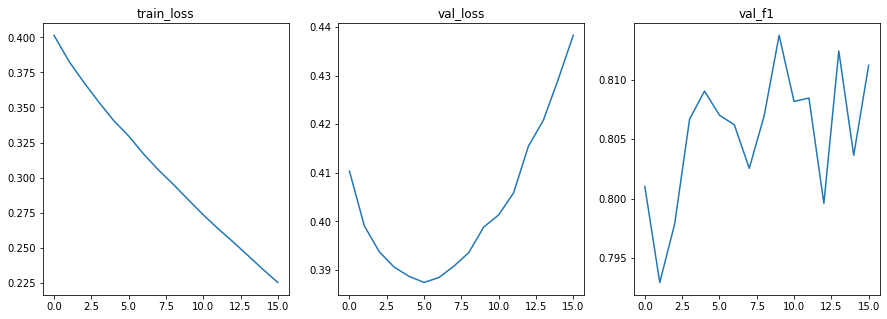


Epoch 16
Training...
Train loss: 0.21511026910122702
Train loss: 0.213056323752887
Train loss: 0.2142265199755247
Train loss: 0.21573256502906196
Train loss: 0.2172564136228342

Evaluating on train...
Val loss: 0.2032167929060319, Val f1: 0.9479740262031555
Val loss: 0.20077071608840555, Val f1: 0.9344315528869629
Val loss: 0.20042905440697303, Val f1: 0.9297088384628296
Val loss: 0.2004997233907096, Val f1: 0.9271498322486877
Val loss: 0.20015647193823738, Val f1: 0.9256939888000488

Evaluating on test...
Val loss: 0.5098640732467175, Val f1: 0.9101951122283936
Val loss: 0.4696101370979758, Val f1: 0.8563823103904724
Val loss: 0.4597204923629761, Val f1: 0.8410423994064331
Val loss: 0.4561741590499878, Val f1: 0.8339763283729553
Val loss: 0.45680762895128946, Val f1: 0.8283811211585999

Epoch 17
Training...
Train loss: 0.20959468930959702
Train loss: 0.20724937838056814
Train loss: 0.20687425322830677
Train loss: 0.20732074182668178
Train loss: 0.2085770213569718

Evaluating on train

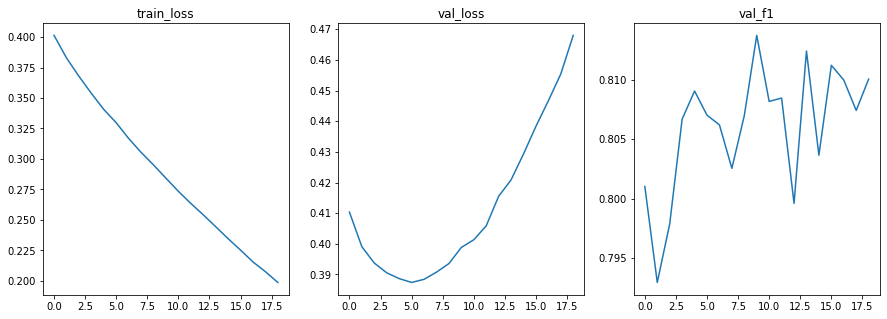


Epoch 19
Training...
Train loss: 0.19054324837291942
Train loss: 0.18897884673830392
Train loss: 0.18919666355045942
Train loss: 0.1909536250846849
Train loss: 0.19075367008817606

Evaluating on train...
Val loss: 0.17673462673145182, Val f1: 0.962469220161438
Val loss: 0.17455903818641882, Val f1: 0.9479337334632874
Val loss: 0.17386569928091306, Val f1: 0.9432006478309631
Val loss: 0.17342888654993593, Val f1: 0.9407718777656555
Val loss: 0.17334562034785062, Val f1: 0.9390526413917542

Evaluating on test...
Val loss: 0.5470377802848816, Val f1: 0.9030321836471558
Val loss: 0.5023975477499121, Val f1: 0.8499217629432678
Val loss: 0.491999177978589, Val f1: 0.8336555361747742
Val loss: 0.4878547625882285, Val f1: 0.8270217180252075
Val loss: 0.4879217581315474, Val f1: 0.8218175768852234


In [69]:
losses, losses_eval, f1s, f1s_eval = train_eval(model, train_iterator, val_iterator, optimizer, criterion)